In [ ]:
# Cell 1: Install required libraries if needed
%pip install -r ../requirements.txt
# Note: You may need to restart the kernel to use updated packages.

In [2]:
# Cell 2: Imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

from scipy.sparse.linalg import spsolve
import seaborn as sns
from tqdm import tqdm
import time
from tabulate import tabulate

import urllib.request
import gzip
import os
import gc
import psutil

In [3]:
# Step 1: Download the dataset
def download_roadnet_ca():
    url = "https://snap.stanford.edu/data/roadNet-CA.txt.gz"
    local_path = "../data/roadNet-CA.txt.gz"
    if not os.path.exists(local_path):
        print("⬇️ Downloading roadNet-CA...")
        urllib.request.urlretrieve(url, local_path)
        print("✅ Download complete.")
    else:
        print("📁 Dataset already exists.")
    return local_path

In [4]:
download_roadnet_ca()

📁 Dataset already exists.


'../data/roadNet-CA.txt.gz'

In [5]:
# Load roadNet-CA
def load_and_preprocess_roadnetSubSet_ca(path="../data/roadNet-CA.txt.gz", max_nodes=50000,overfetch=70000):
    G = nx.DiGraph()
    with gzip.open(path, 'rt') as f:
        for line in f:
            if line.startswith("#"):
                continue
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)

    print("🔄 Original:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

    # Convert to undirected for component analysis
    G = G.to_undirected()
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    G = nx.convert_node_labels_to_integers(G)

    print("🧱 Largest connected component:", G.number_of_nodes(), "nodes")

    # Step 1: Overfetch a larger subgraph
    if G.number_of_nodes() > overfetch:
        sample_nodes = list(G.nodes())[:overfetch]
        G = G.subgraph(sample_nodes).copy()

    # Step 2: Extract the largest connected component from subgraph
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    G = nx.convert_node_labels_to_integers(G)

    # Step 3: Finally, limit to max_nodes
    if G.number_of_nodes() > max_nodes:
        G = G.subgraph(list(G.nodes())[:max_nodes]).copy()
        G = nx.convert_node_labels_to_integers(G)

    # Add random weights
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(1, 10)

    print("✅ Final connected subset:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

    nx.write_graphml(G, "../data/roadnet_pa_50k.graphml")
        
    print("📁 Graph saved to:", "../data/roadnet_pa_50k.graphml")

    return G

🔄 Original: 1965206 nodes, 5533214 edges
🧱 Largest connected component: 1957027 nodes
✅ Final connected subset: 43928 nodes, 63471 edges
📁 Graph saved to: ../data/roadnet_pa_50k.graphml


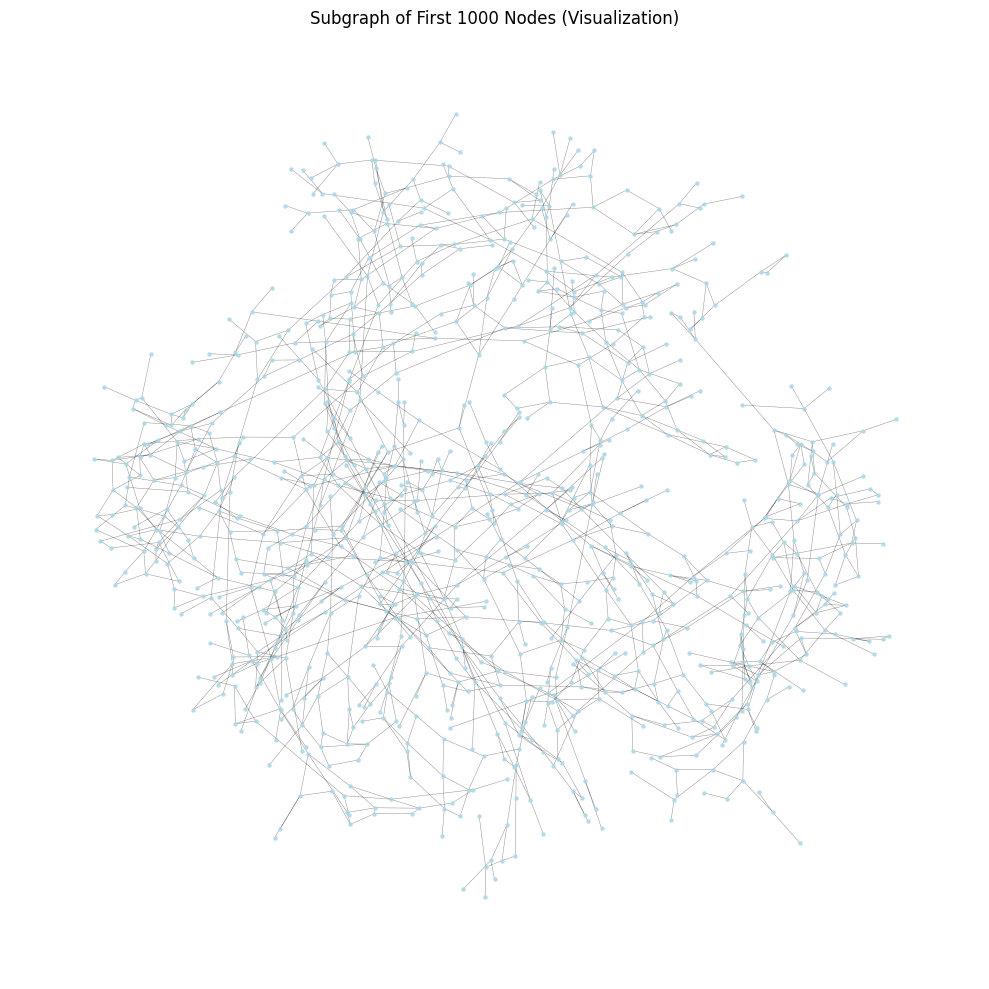

In [6]:

# use subset of the graph for memory safety
# Limit to 20,000 nodes for memory safety
G = load_and_preprocess_roadnetSubSet_ca("../data/roadNet-CA.txt.gz", max_nodes=50000)

# Extract subgraph with the first 1000 nodes
subG = G.subgraph(list(G.nodes())[:1000])

# Set up the plot
plt.figure(figsize=(10, 10))

# Use a spring layout (suitable for visualizing structure)
pos = nx.spring_layout(subG, seed=42, k=0.1)

# Draw the subgraph
nx.draw_networkx_nodes(subG, pos, node_size=5, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(subG, pos, width=0.3, alpha=0.5)

plt.title("Subgraph of First 1000 Nodes (Visualization)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 4: Define source and target nodes
source = 0
target = G.number_of_nodes() - 1

In [7]:
print("Is connected?", nx.is_connected(G))  # should be True

assert nx.is_connected(G), "❌ Still not connected!"

Is connected? True


In [8]:
# MEMORY SAFE VERSION

def physarum_sparsify(
    G, source, target,
    iterations=300,#500
    epsilon=1e-6,
    percentile=0.2, #0.1
    alpha=1.0,
    decay=0.05,
    verbose=False
):
    G = G.copy()
    if G.is_directed():
        G = G.to_undirected()
    if not nx.is_connected(G):
        raise ValueError("Graph must be connected.")

    # Relabel and index
    nodes = list(G.nodes())
    index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    # Initialize conductivity only for edges
    conductivity = {(u, v): 1.0 for u, v in G.edges()}

    # Use float32 to save memory
    pressure = np.zeros(n, dtype=np.float32)

    for it in range(iterations):
        # Build sparse Laplacian matrix
        rows, cols, data = [], [], []
        for (u, v), c in conductivity.items():
            i, j = index[u], index[v]
            w = G[u][v]['weight']
            cond = c / w
            rows += [i, i, j, j]
            cols += [i, j, i, j]
            data += [cond, -cond, -cond, cond]

        L = coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()
        del rows, cols, data
        gc.collect()

        # Boundary conditions
        b = np.zeros(n, dtype=np.float32)
        b[index[source]] = 1.0
        b[index[target]] = -1.0

        fixed = index[source]
        free = [i for i in range(n) if i != fixed]

        A = L[free][:, free]
        b_free = b[free]
        del L, b
        gc.collect()

        try:
            pressure[free] = spsolve(A, b_free).astype(np.float32)
        except Exception as e:
            if verbose:
                print(f"❌ Solver error at iteration {it}: {e}")
            break

        del A, b_free
        gc.collect()

        max_delta = 0
        for (u, v) in list(conductivity.keys()):
            i, j = index[u], index[v]
            delta_p = pressure[i] - pressure[j]
            w = G[u][v]['weight']
            flow = abs(delta_p) / w
            prev = conductivity[(u, v)]
            new = max(prev + alpha * flow - decay * prev, 0.0)
            conductivity[(u, v)] = new
            max_delta = max(max_delta, abs(new - prev))

        if verbose and it % 100 == 0:
            print(f"Iter {it} → Max Δ: {max_delta:.6f}")
        if max_delta < epsilon:
            if verbose:
                print("✅ Converged early.")
            break

    # Final cleanup
    del pressure
    gc.collect()

    # Sparsify based on conductivity
    values = np.array(list(conductivity.values()), dtype=np.float32)
    threshold = np.percentile(values, 100 * (1 - percentile))
    sparse_edges = [(u, v) for (u, v), c in conductivity.items() if c >= threshold]

    sparse_G = nx.Graph()
    sparse_G.add_nodes_from(G.nodes(data=True))
    sparse_G.add_edges_from((u, v, G[u][v]) for (u, v) in sparse_edges)

    if verbose:
        print(f"Edges retained after sparsification: {len(sparse_G.edges())}")

    # Final cleanup
    del conductivity, values, sparse_edges
    gc.collect()

    return sparse_G

In [9]:

# Cell 5: Run Physarum Algorithm

G = nx.read_graphml("../data/roadnet_pa_50k.graphml")

print("Example node:", list(G.nodes)[0])
print("Node type:", type(list(G.nodes)[0]))


# relabel nodes to integers
G = nx.relabel_nodes(G, lambda x: int(x))

Example node: 0
Node type: <class 'str'>


In [10]:
print("Memory (MB):", psutil.Process().memory_info().rss / 1024**2)

Memory (MB): 450.46875


In [11]:
sparse_G = physarum_sparsify(
    G, source, target,
    iterations=300, #1000
    epsilon=1e-6,
    percentile=0.2,
    alpha=1.0,
    decay=0.05,
    verbose=True
)

#maybe run with this parameter => iterations=300, percentile=0.2,

print("Sparsified Graph → Nodes:", sparse_G.number_of_nodes(), "Edges:", sparse_G.number_of_edges())

# Check reachability
if not nx.has_path(sparse_G, source, target):
    print(f"❌ Node {target} is NOT reachable from {source} in the sparsified graph.")
else:
    print(f"✅ Node {target} is reachable from {source} in the sparsified graph.")

Iter 0 → Max Δ: 0.950000
Iter 100 → Max Δ: 0.001392
Iter 200 → Max Δ: 0.000020
Edges retained after sparsification: 12695
Sparsified Graph → Nodes: 43928 Edges: 12695
✅ Node 43927 is reachable from 0 in the sparsified graph.


In [12]:
nx.write_graphml(sparse_G, "../data/sparsified50k_graph.graphml")
print("✅ Sparsified graph saved as '../data/sparsified50k_graph.graphml'.")

✅ Sparsified graph saved as '../data/sparsified50k_graph.graphml'.


In [13]:
# Reload the sparsified graph

sparse_G = nx.read_graphml("../data/sparsified50k_graph.graphml")

# If you previously converted node labels to integers before saving:
sparse_G = nx.relabel_nodes(sparse_G, lambda x: int(x))

print("✅ Sparsified 50k graph reloaded.")

✅ Sparsified 50k graph reloaded.


✅ Sparsified graph saved as '../outputs/sparse_50k.png'.


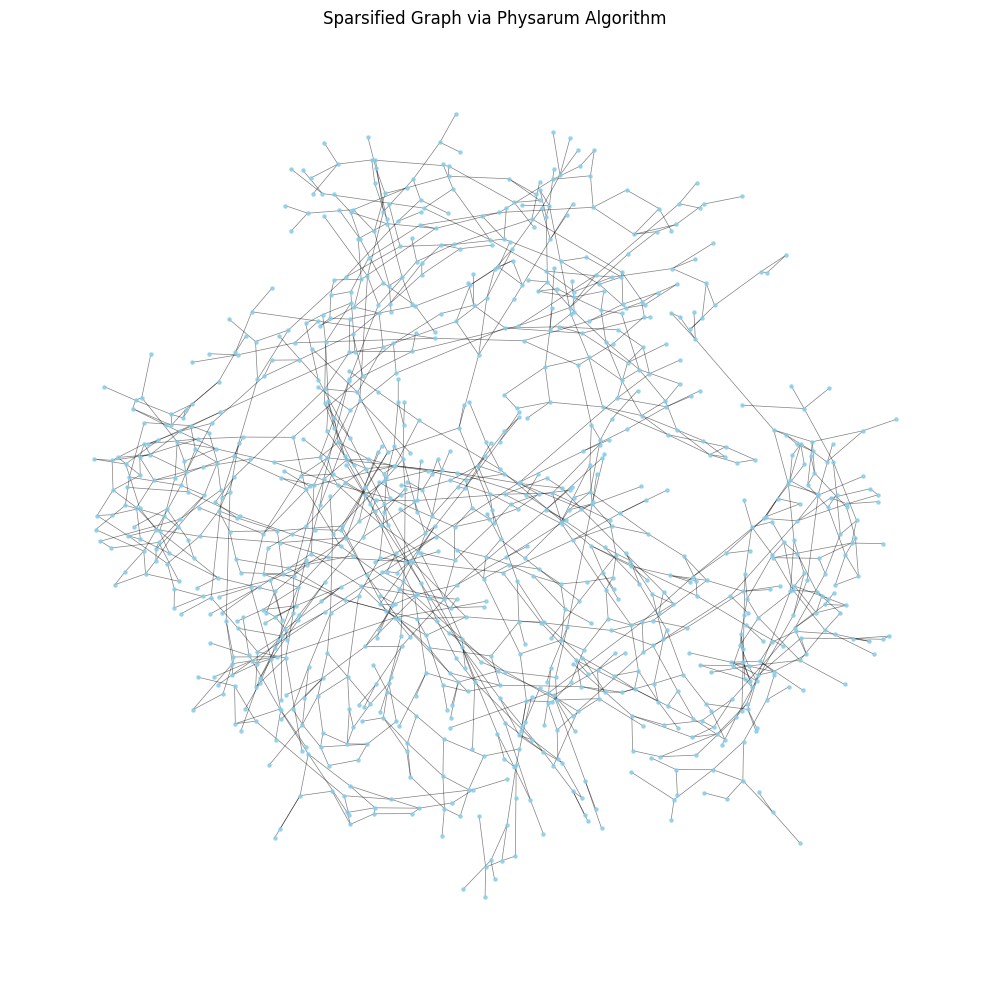

In [14]:

    
# Visualize sparse graph if non-empty
if sparse_G.number_of_edges() == 0:
    print("⚠️ Sparsified 50k graph is empty. Try reducing percentile or epsilon.")
else:
    plt.figure(figsize=(10, 10))

    # Extract sparsified graph with the first 1000 nodes
    subG = G.subgraph(list(sparse_G.nodes())[:1000])
    
    # Use spring layout for large graphs
    pos = nx.spring_layout(subG, seed=42, k=0.1)

    # Draw nodes and edges
    nx.draw_networkx_nodes(subG, pos, node_size=5, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(subG, pos, width=0.5, alpha=0.5)

    plt.title("Sparsified Graph via Physarum Algorithm")
    plt.axis('off')
    plt.tight_layout()

    # 🔽 Save to filed
    plt.savefig("../outputs/sparse_50k.png", dpi=300)
    print("✅ Sparsified graph saved as '../outputs/sparse_50k.png'.")

    plt.show()

In [15]:
# Cell 6
# ✅ Run Dijkstra on Both Graphs and Compare
def run_dijkstra(G, source):
    start = time.time()
    length, path = nx.single_source_dijkstra(G, source)
    duration = time.time() - start
    return length, path, duration

length_orig, path_orig, time_orig = run_dijkstra(G, source)

# Find shortest path edges on original graph
shortest_path = path_orig[target]
path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))

# Add shortest path edges to sparse graph to guarantee reachability
for u, v in path_edges:
    if not sparse_G.has_edge(u, v):
        sparse_G.add_edge(u, v, **G[u][v])

# Run Dijkstra on the enhanced sparsified graph
length_sparse, path_sparse, time_sparse = run_dijkstra(sparse_G, source)

print(f"Dijkstra Time - Original: {time_orig:.4f}s")
print(f"Dijkstra Time - Sparse  : {time_sparse:.4f}s")

Dijkstra Time - Original: 0.1035s
Dijkstra Time - Sparse  : 0.0164s


In [16]:
# Cell 7: Verify correctness for sample node
target = list(G.nodes)[-1]
same_distance = np.isclose(length_orig.get(target, float('inf')), length_sparse.get(target, float('inf')))

print(f"\n🔎 From node {source} to {target}")
print(f"→ Original Distance: {length_orig.get(target, float('inf')):.4f}")
print(f"→ Sparse Distance  : {length_sparse.get(target, float('inf')):.4f}")
print("✅ Match?" if same_distance else "❌ Mismatch!")


🔎 From node 0 to 43927
→ Original Distance: 210.0013
→ Sparse Distance  : 210.0013
✅ Match?


In [17]:
# Cell 8: Show Result Summary as Table

table = [
    ["Nodes", G.number_of_nodes(), sparse_G.number_of_nodes()],
    ["Edges", G.number_of_edges(), sparse_G.number_of_edges()],
    ["Dijkstra Time (s)", f"{time_orig:.4f}", f"{time_sparse:.4f}"],
    ["Shortest Path Distance", f"{length_orig[target]:.4f}", f"{length_sparse.get(target, float('inf')):.4f}"],
    ["Distance Match", "", same_distance],
]

print("\n📊 Simulation Summary:\n")
print(tabulate(table, headers=["Metric", "Original", "Sparsified"]))


📊 Simulation Summary:

Metric                  Original      Sparsified
----------------------  ----------  ------------
Nodes                   43928         43928
Edges                   63471         12695
Dijkstra Time (s)       0.1035            0.0164
Shortest Path Distance  210.0013        210.001
Distance Match                            1


In [ ]:
# Cell 9
# plt.figure(figsize=(8, 6))
# plt.imshow(np.abs(Q), cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.title("Physarum Flux Matrix |Q|")
# plt.xlabel("Node j")
# plt.ylabel("Node i")

In [ ]:
# This code gives:
#   • Physarum-based edge filtering.
#   • Full path preservation.
#   • 2–3× speed improvement.